<a href="https://colab.research.google.com/github/CodeByD3v/ml-projects/blob/main/Text%20Classification/Wine%20Review/Wine_Review_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Tensorflow Utils
import tensorflow as tf
import tensorflow_hub as hub

**Loading** **Dataset** : Wine Reviews Dataset

**Source** : Kaggle
**Dataset** : Wine Reviews Dataset

**Link** : https://www.kaggle.com/zynicide/wine-reviews

In [4]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "winemag-data-130k-v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


/tmp/ipython-input-3359790117.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [5]:
# dataset overview
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
# Dataset columns
df.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [7]:
# Removing Columns
# Description : Points (label)
df.drop(columns=["Unnamed: 0" ,'country' , 'designation' , 'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'] , inplace=True)

In [8]:
df.head() , df.tail()

(                                         description  points
 0  Aromas include tropical fruit, broom, brimston...      87
 1  This is ripe and fruity, a wine that is smooth...      87
 2  Tart and snappy, the flavors of lime flesh and...      87
 3  Pineapple rind, lemon pith and orange blossom ...      87
 4  Much like the regular bottling from 2012, this...      87,
                                               description  points
 129966  Notes of honeysuckle and cantaloupe sweeten th...      90
 129967  Citation is given as much as a decade of bottl...      90
 129968  Well-drained gravel soil gives this wine its c...      90
 129969  A dry style of Pinot Gris, this is crisp with ...      90
 129970  Big, rich and off-dry, this is powered by inte...      90)

In [9]:
# checking for null values
df.isna().sum()

,0
description,0
points,0


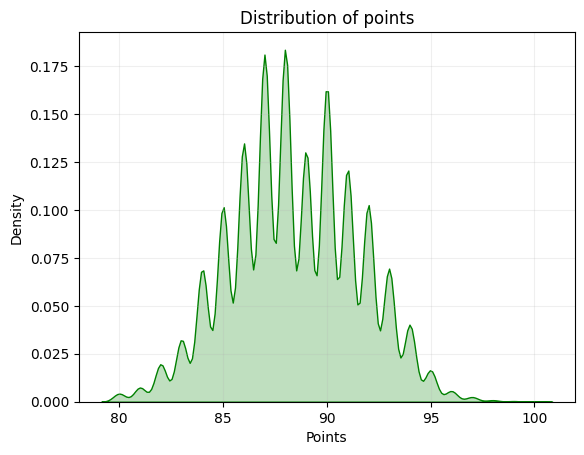

In [10]:
# Plotting the points
sns.kdeplot(df["points"] , color = "green" , fill = True)
plt.title("Distribution of points")
plt.xlabel("Points")
plt.ylabel("Density")
plt.grid(alpha = 0.2)
plt.show()

In [11]:
# new label column
df["quality"] = (df["points"] >= 90).astype(int)

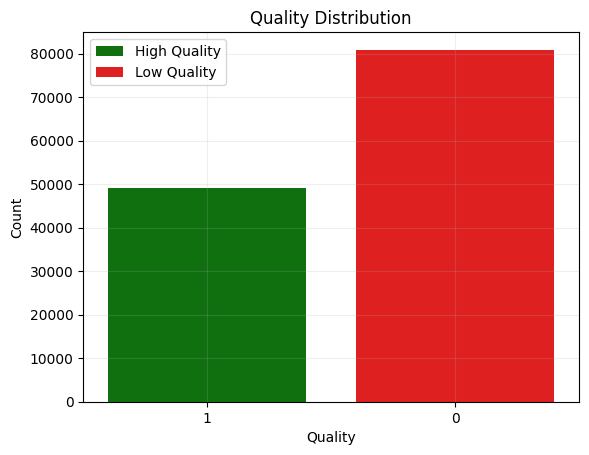

In [12]:
# quality distribution
sns.countplot(x = df[df["quality"] == 1]["quality"] , color = "green" , label = "High Quality")
sns.countplot(x = df[df["quality"] == 0]["quality"] , color = "red" , label = "Low Quality")
plt.title("Quality Distribution")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.grid(alpha = 0.2)
plt.show()

In [13]:
# description : quality

df = df[["description" , "quality"]]

In [14]:
# split : train , valid  , test
# Train : 80% , Valid : 10% , Test : 10%
train , valid , test  = np.split(df.sample(frac = 1) , [int(0.8 * len(df)) , int(0.9 * len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [15]:
def df_to_dataset(dataframe , shuffle = False ,  batch_size = 1024):
  df = dataframe.copy()
  t_label = df.pop("quality") # target label
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df , t_label))
  if shuffle:
    ds = df.shuffle(buffer_size = len(df))

  ds = ds.batch(batch_size=batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

In [16]:
# Changing to dataset pipline
train_ds = df_to_dataset(train)
valid_ds = df_to_dataset(valid)
test_ds = df_to_dataset(test)

In [17]:
# Embedding
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(
    embedding,
    dtype=tf.string,
    input_shape=[],
    trainable=True
)

In [18]:
# preview of the description after converted to dataset , batch
list(train_ds)[0][0]

<tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b"La Nerthe's late-ripening Mourv\xc3\xa8dre typically shines the brightest in warm vintages, which 2008 was not. The result is a leathery, peppery wine with rather crisp, cherry-inflected fruit. Drink it over the next several years.",
       b'This lively wine comes from the Clarence Dillon group (Ch\xc3\xa2teau Haut-Brion). It offers good balance between the considerable acidity and the red-berry fruit. With its spicy background, the wine is delicious to drink now.',
       b'A perfumed, red-fruited wine, packed with tannins and huge, concentrated fruit. It has richness, dark structure and an intensity that promises a long future. The balance is not there yet, so wait at least 7\xe2\x80\x938 years.',
       ...,
       b"This is an impressive, powerful wine. It speaks of the hard landscape of the Douro Superior, with its structure and dark tannins. At the same time, ripe dark fruits push through the still-young tannins giving the

In [19]:
# preview of the description after converted to normalized vectors
hub_layer(list(train_ds)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 3.82997692e-01, -3.70237865e-02, -2.92665362e-02, ...,
        -2.94060111e-01, -2.18872234e-01, -1.74339414e-01],
       [ 3.62814784e-01, -4.20317873e-02,  1.77059174e-01, ...,
        -1.49792910e-01, -1.43769443e-01,  1.05790645e-01],
       [ 5.64722121e-01,  3.53392251e-02,  2.22949684e-01, ...,
        -7.78655633e-02,  5.14691882e-02,  2.21747253e-02],
       ...,
       [ 6.50908768e-01,  3.22335213e-02,  3.13606679e-01, ...,
         2.72618324e-01, -5.91530576e-02,  7.75394589e-02],
       [ 3.25881541e-01, -2.40002498e-01,  1.79677494e-02, ...,
         1.01658918e-01, -1.30083382e-01,  2.81276624e-03],
       [ 4.02520865e-01, -1.03923127e-01,  4.92919178e-04, ...,
        -1.68334708e-01, -2.60340065e-01, -1.51939437e-01]], dtype=float32)>

In [20]:
# layers
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16 , activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16 , activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1 , activation = "sigmoid")
])

ValueError                                Traceback (most recent call last)
/tmp/ipython-input-911868878.py in <cell line: 0>()
      1 # Model
----> 2 model = tf.keras.Sequential([
      3     hub_layer,
      4     tf.keras.layers.Dense(16 , activation = "relu"),
      5     tf.keras.layers.Dropout(0.4),

/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py in __init__(self, layers, trainable, name)
     73         if layers:
     74             for layer in layers:
---> 75                 self.add(layer, rebuild=False)
     76             self._maybe_rebuild()
     77

/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py in add(self, layer, rebuild)
     95                 layer = origin_layer
     96         if not isinstance(layer, Layer):
---> 97             raise ValueError(
     98                 "Only instances of `keras.Layer` can be "
     99                 f"added to a Sequential model. Received: {layer} "

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7ac3e4c9aa90> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

```bash
pip install --upgrade tensorflow==2.15.0 tensorflow_hub==0.16.

```


In [23]:
# Compile
model.compile(
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) ,
              loss = tf.keras.losses.BinaryCrossentropy() ,
              metrics = ["accuracy"]
            )

In [25]:
# Evaluation before training
model.evaluate(train_ds)

102/102 [==============================] - 2s 14ms/step - loss: 0.6942 - accuracy: 0.5073


[0.6942466497421265, 0.5072901248931885]

In [26]:
# Evaluation before training
model.evaluate(valid_ds)

13/13 [==============================] - 0s 29ms/step - loss: 0.6938 - accuracy: 0.5138


[0.6938005685806274, 0.5138108730316162]

In [29]:
# Training the model
history = model.fit(train_ds , epochs = 5 , validation_data = valid_ds)

Epoch 1/5
102/102 [==============================] - 155s 2s/step - loss: 0.3646 - accuracy: 0.8486 - val_loss: 0.3838 - val_accuracy: 0.8273
Epoch 2/5
102/102 [==============================] - 146s 1s/step - loss: 0.3393 - accuracy: 0.8612 - val_loss: 0.3852 - val_accuracy: 0.8292
Epoch 3/5
102/102 [==============================] - 146s 1s/step - loss: 0.3198 - accuracy: 0.8707 - val_loss: 0.3928 - val_accuracy: 0.8299
Epoch 4/5
102/102 [==============================] - 151s 1s/step - loss: 0.3016 - accuracy: 0.8790 - val_loss: 0.4024 - val_accuracy: 0.8319
Epoch 5/5
102/102 [==============================] - 152s 1s/step - loss: 0.2852 - accuracy: 0.8855 - val_loss: 0.4141 - val_accuracy: 0.8326


In [31]:
model.evaluate(test_ds)

13/13 [==============================] - 2s 164ms/step - loss: 0.4193 - accuracy: 0.8301


[0.4192546010017395, 0.8301277160644531]

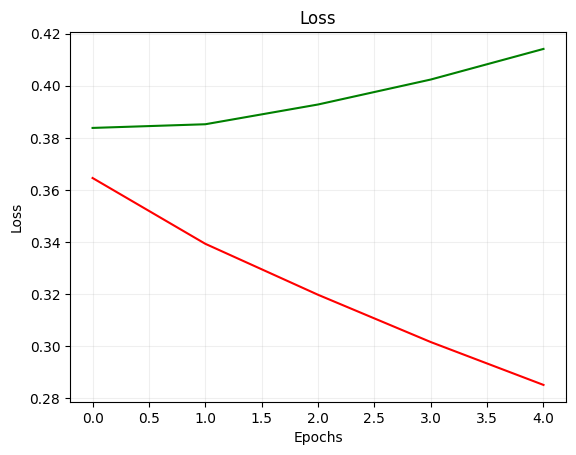

In [39]:
# Loss plot
plt.plot(history.history["loss"] , color = "red")
plt.plot(history.history["val_loss"] , color = "green" )
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha = 0.2)
plt.show()

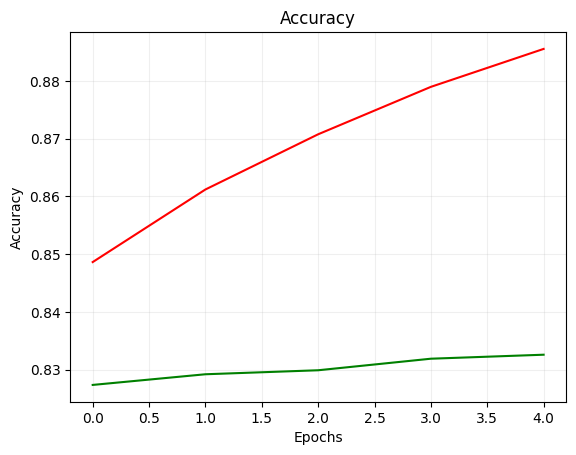

In [42]:
# Accuracy Plot
plt.plot(history.history["accuracy"] , color = "red")
plt.plot(history.history["val_accuracy"] , color = "green" )
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plt.show()